Promita Rahee Sidker:
COSC 74 - Final Project

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_auc_score, roc_curve, silhouette_score, adjusted_rand_score
from sklearn.preprocessing import label_binarize, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

Load the training dataset and clean it.

In [14]:
data = pd.read_csv('train.csv')

# Long list of engineered/synthetic features
# I trial and errored with many different kinds of numeric features to diversify the feature set for the classifiers
# and see if it helped use the text from the review and summary for the F1 macro score
# The following features helped. E.g. customers are more likely to use !s and ?s for negative reviews which helps 
# inform the classifier on overall rating. Very positive and negative reviews tend to be longer too
FEATURES = ['text', 'category', 'char_count', 'word_count', 'exclaimation_count', 'period_count', 'question_count', 'uppercase', 'lowercase']

# Develop numeric features from text
def count_uppercase_words(review):
    uppercase_words = 0
    for word in review.split():
        if word.isupper():
            uppercase_words += 1
    return uppercase_words

def count_lowercase_words(review):
    lowercase_words = 0
    for word in review.split():
        if word.islower():
            lowercase_words += 1
    return lowercase_words

def add_features(data):
    # Combine reviewText and summary for developing text features.
    data = data.copy()
    data['text'] = data['reviewText'] + ' ' + data['summary']
    
    try:
        data = data[['id', 'text', 'category', 'overall']].dropna()
    except:
        data = data[['id', 'text', 'category']].dropna()

    data['char_count'] = data['text'].str.len()
    data['word_count'] = data['text'].str.split().apply(len)
    data['exclaimation_count'] = data['text'].str.count('!')
    data['period_count'] = data['text'].str.count('.')
    data['question_count'] = data['text'].str.count(r'\?')
    data['uppercase'] = data['text'].apply(count_uppercase_words)
    data['lowercase'] = data['text'].apply(count_lowercase_words)
    return data

# Make X, y using synthetic features and overall
data = add_features(data)

X = data[FEATURES]
y = data['overall']
classes = sorted(y.unique())

Preprocess features from above.

I used some trial and error to compare F1 macro scores with various vectorizers and scaling techniques. This combination of using my synthetic features as numeric inputs, and category as worked best.

In [15]:
preprocessor = ColumnTransformer(transformers=[
    ('text1', TfidfVectorizer(max_features=3500), 'text'),
    ('category1', TfidfVectorizer(), 'category'), # also train on the words inside the category column for the classifier 
    ('category2', OneHotEncoder(handle_unknown='ignore'), ['category']),
    ('word_features', StandardScaler(), ['char_count', 'word_count', 'exclaimation_count', 'period_count', 'question_count', 'uppercase', 'lowercase'])
])

**Binary classification**

Binarize labels by simply comparing the rating > cutoff.

Then run full suite of models with grid-based parameter searching. I used some trial and error and looking up scikit documentation to figure out which parameters could be tuned for each of the models I chose (logistic regression, naive bayes and SVM).

Note: SVM warns about not converging and requiring more than the max_iter passed. I tried fixing this with a larger number of iterations, but it still complained.

I also tried using a Perceptron model, but it suffered in performance on my machine. Grid-based parameter search helps find the parmeters which work best for each of the following models. Linear regression classically seems to work best for this kind of classification. Naive bayes had poor performance on Gaussian and Multinomial modes, and had to to be optimized to use the negative and non-zero inputs from the numeric engineered features too.

In [16]:
def convert_to_binary(y, cutoff):
    return (y > cutoff).astype(int)

models = [
    ('Logistic Regression', LogisticRegression(max_iter=3000)),
    ('Naive Bayes', BernoulliNB()),
    ('SVM', LinearSVC(max_iter=3000))
]

parameter_grids = [
    {'classifier__C': [0.1, 0.5, 1, 10]},
    {},  # Naive Bayes has no tunable hyperparams here
    {'classifier__C': [0.1, 0.5, 1, 10], 'classifier__loss': ['hinge', 'squared_hinge']}
]

def binary_classifier(cutoff):
    y_binary = convert_to_binary(y, cutoff)
    X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, stratify=y_binary, random_state=42)

    best_score = -1
    best_model = None
    best_name = ""
    best_params = None

    for i, (name, model) in enumerate(models):
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', model)
        ])
        
        # Perform 5-folds CV on parameter combinations
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        grid = GridSearchCV(pipeline, param_grid=parameter_grids[i], cv=cv, scoring='f1_macro', n_jobs=-1)
        
        print(f"Parameter grid search for {name}...")
        grid.fit(X_train, y_train)
        
        print(f"Best params: {grid.best_params_}")
        # print(f"F1 macro: {grid.best_score_}")
        
        # Evaluate on validation set
        best = grid.best_estimator_
        y_pred = best.predict(X_test)
        f1 = f1_score(y_test, y_pred, average='macro')
        accuracy = accuracy_score(y_test, y_pred)
        
        try:
            y_proba = best.predict_proba(X_test)
            y_score = y_proba[:, 1]
        except:
            # Some models don't have proba, so used their decision functions as a documented fix
            dec = best.decision_function(X_test)
            y_score = (dec - dec.min()) / (dec.max() - dec.min())

        roc_auc = roc_auc_score(y_test, y_score)

        print(f"Accuracy: {accuracy}")
        print(f"F1 macro: {f1}")
        print(f"ROC AUC: {roc_auc}")

        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(6, 5))
        plt.imshow(cm, cmap=plt.cm.Blues)
        plt.title(f"Confusion Matrix for {name}")
        plt.colorbar()
        plt.xticks([0, 1], [0, 1])
        plt.yticks([0, 1], [0, 1])
        for a in range(2):
            for b in range(2):
                plt.text(b, a, cm[a, b], ha='center', va='center', color="black")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.tight_layout()
        plt.show()

        # ROC Curve
        fpr, tpr, _ = roc_curve(y_test, y_score)
        plt.plot(fpr, tpr, label="ROC Curve")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"AUC ROC Curve for {name}")
        plt.legend()
        plt.grid(True)
        plt.show()

        # Track best model
        if f1 > best_score:
            best_score = f1
            best_model = best
            best_name = name
            best_params = grid.best_params_

    print()
    print(f'Best model chosen: {best_name}, params={best_params}')
    print(f'F1 Macro Score: {best_score}')
    print()

    # Run the best model on the test.csv file for Kaggle
    test_df = pd.read_csv("test.csv")
    test_df = test_df[['id', 'reviewText', 'summary', 'category']].copy()
    test_df['reviewText'] = test_df['reviewText'].fillna('')
    test_df['summary'] = test_df['summary'].fillna('')
    test_df['category'] = test_df['category'].fillna('unknown')
    test_df = add_features(test_df)

    # Predict
    test_X = test_df[FEATURES]
    test_preds = best_model.predict(test_X)

    submission = pd.DataFrame({
        'id': test_df['id'],
        'predicted': test_preds
    })
    
    submission.to_csv(f"test_submission_{cutoff}.csv", index=False)

Parameter grid search for Logistic Regression...
Best params: {'classifier__C': 10}
Accuracy: 0.8644851807435326
F1 macro: 0.7755686738469066
ROC AUC: 0.907761540582927


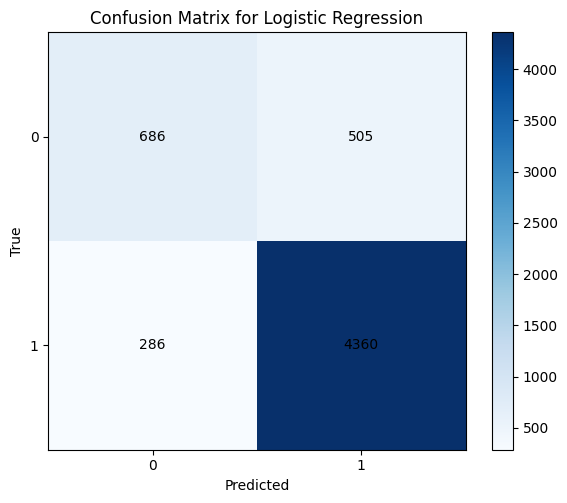

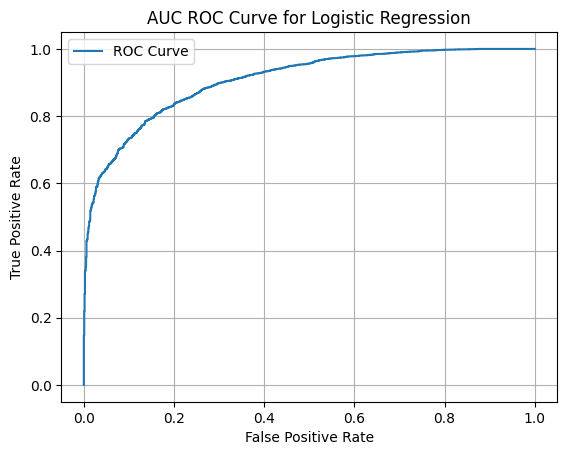

Parameter grid search for Naive Bayes...
Best params: {}
Accuracy: 0.8444406373136886
F1 macro: 0.7766950710750632
ROC AUC: 0.8774074319051662


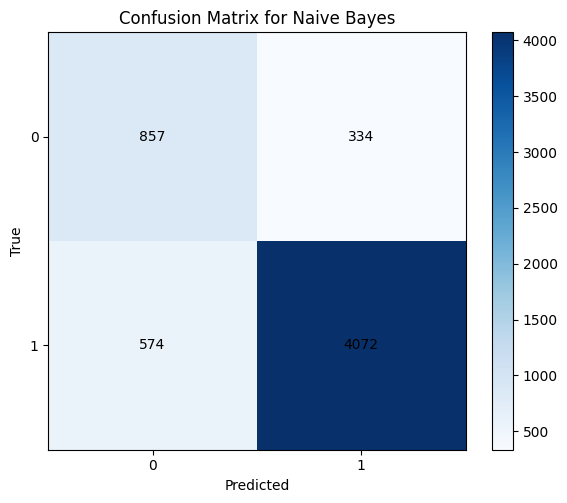

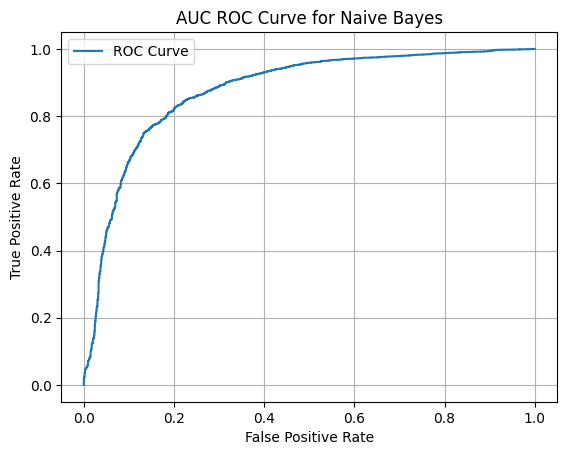

Parameter grid search for SVM...


/opt/homebrew/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number 

Best params: {'classifier__C': 1, 'classifier__loss': 'squared_hinge'}
Accuracy: 0.8637998972074696
F1 macro: 0.773948908935814
ROC AUC: 0.905688668746406


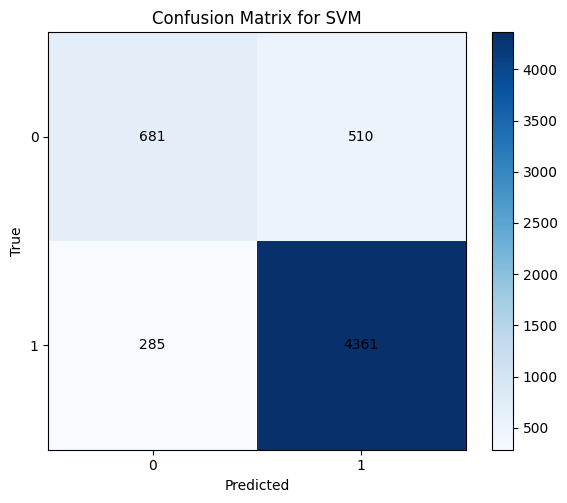

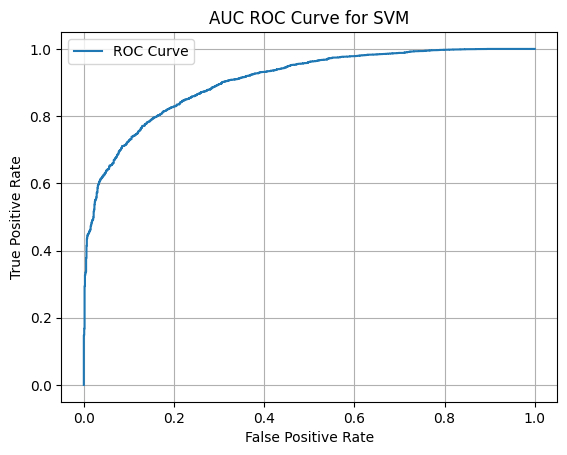


Best model chosen: Naive Bayes, params={}
F1 Macro Score: 0.7766950710750632



In [17]:
binary_classifier(1)

Parameter grid search for Logistic Regression...
Best params: {'classifier__C': 1}
Accuracy: 0.8384444063731369
F1 macro: 0.8303097500299423
ROC AUC: 0.9167333464384497


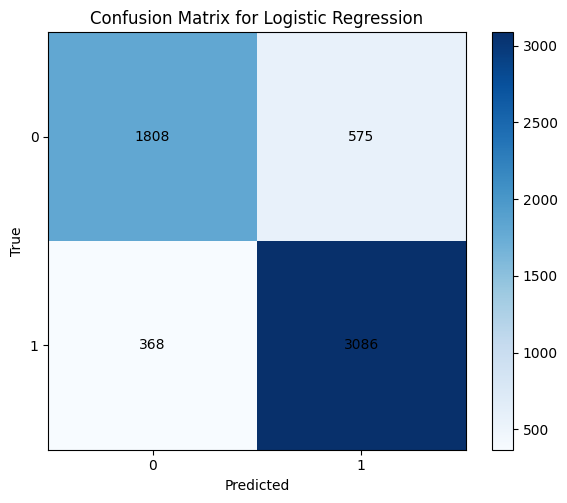

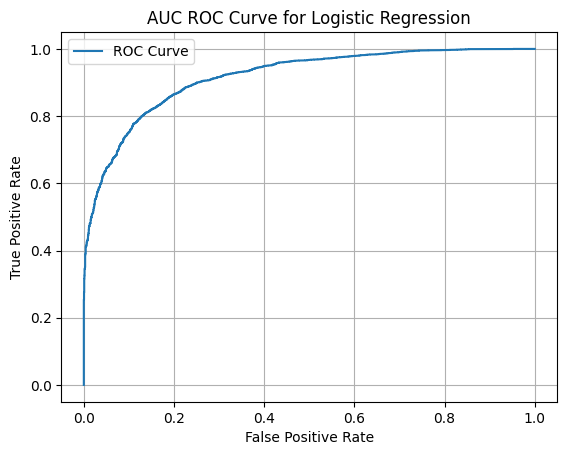

Parameter grid search for Naive Bayes...
Best params: {}
Accuracy: 0.7654617097824225
F1 macro: 0.7529816247529887
ROC AUC: 0.8545880016260712


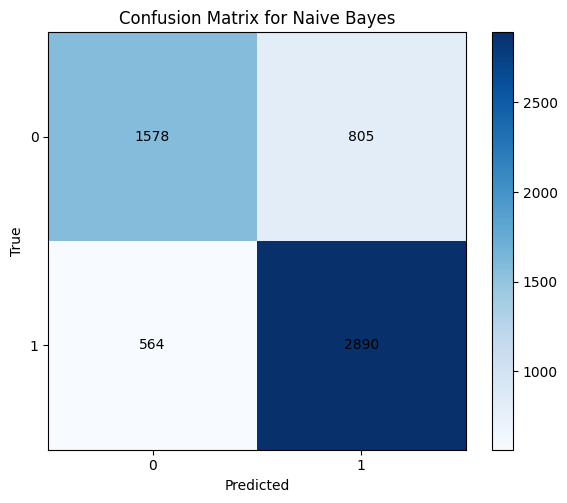

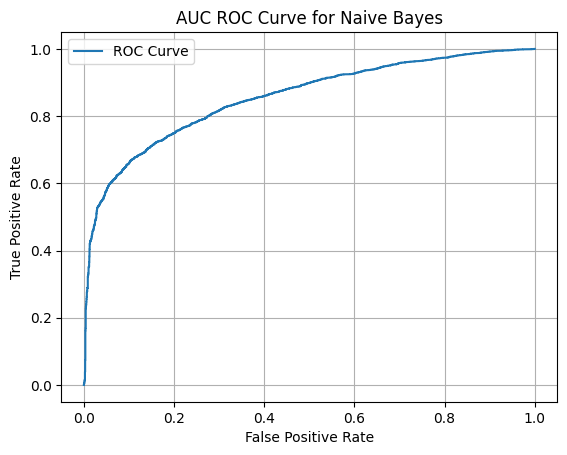

Parameter grid search for SVM...


/opt/homebrew/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number 

Best params: {'classifier__C': 0.1, 'classifier__loss': 'squared_hinge'}
Accuracy: 0.8382730854891212
F1 macro: 0.8300357959124651
ROC AUC: 0.9166157405731243


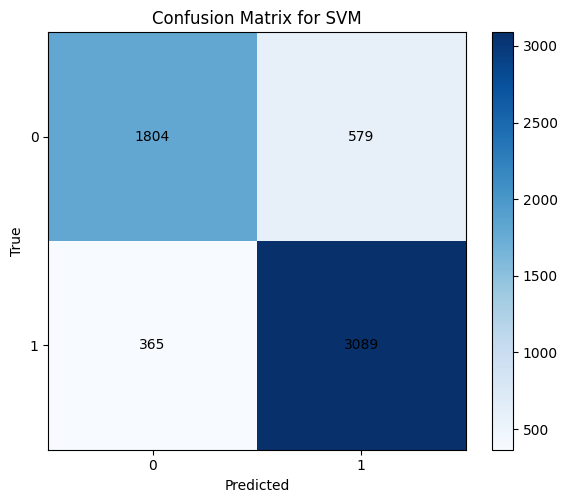

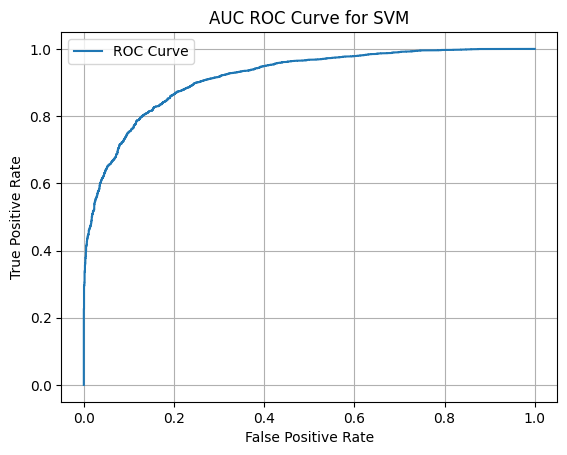


Best model chosen: Logistic Regression, params={'classifier__C': 1}
F1 Macro Score: 0.8303097500299423



In [18]:
binary_classifier(2)

Parameter grid search for Logistic Regression...
Best params: {'classifier__C': 1}
Accuracy: 0.8615727257152647
F1 macro: 0.8514885854917359
ROC AUC: 0.9310799000555932


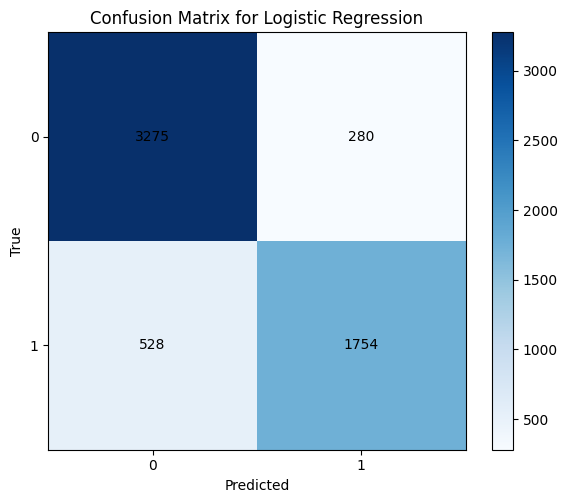

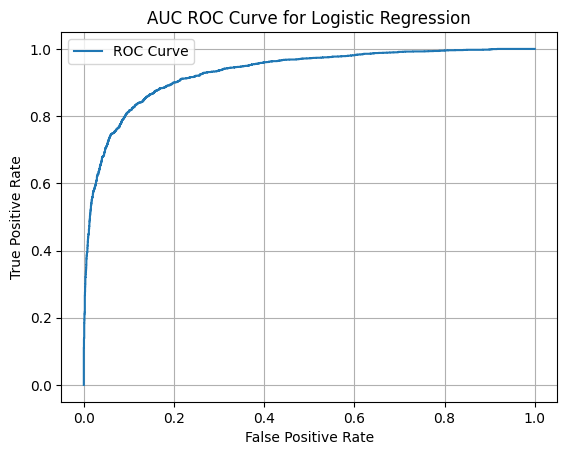

Parameter grid search for Naive Bayes...
Best params: {}
Accuracy: 0.7097824224773
F1 macro: 0.7061723002166886
ROC AUC: 0.8153746497693068


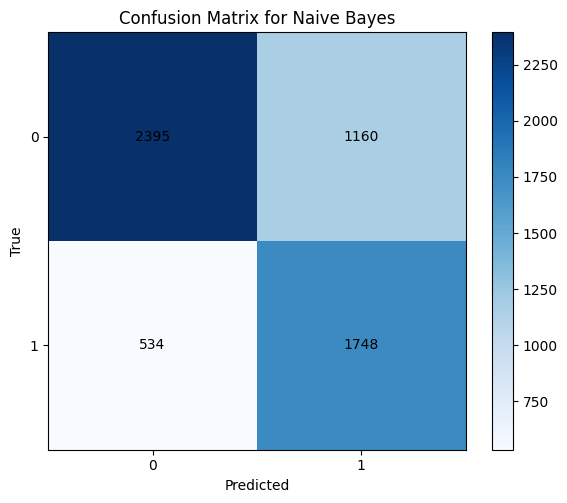

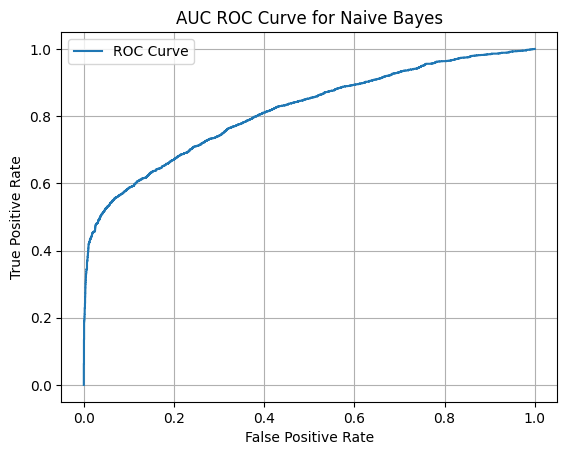

Parameter grid search for SVM...


/opt/homebrew/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number 

Best params: {'classifier__C': 1, 'classifier__loss': 'hinge'}
Accuracy: 0.8626006510193592
F1 macro: 0.8534975024992533
ROC AUC: 0.9277868378590597


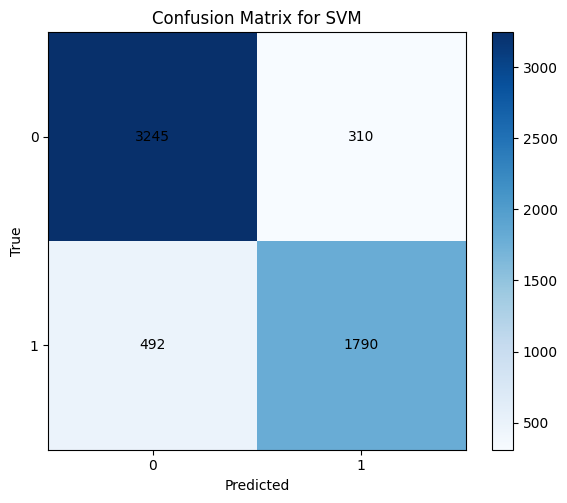

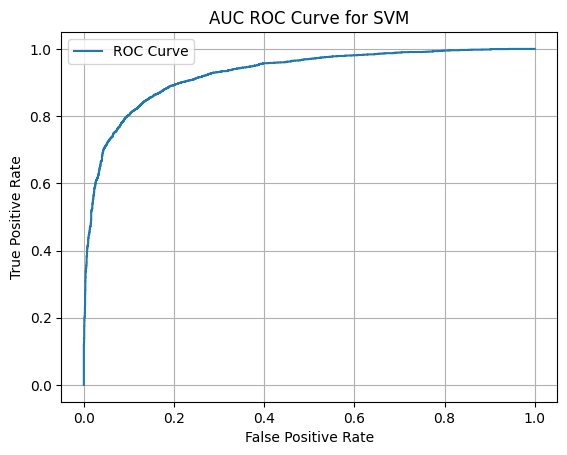


Best model chosen: SVM, params={'classifier__C': 1, 'classifier__loss': 'hinge'}
F1 Macro Score: 0.8534975024992533



In [19]:
binary_classifier(3)

Parameter grid search for Logistic Regression...
Best params: {'classifier__C': 10}
Accuracy: 0.8924104848381018
F1 macro: 0.8154745724283381
ROC AUC: 0.9218683402387763


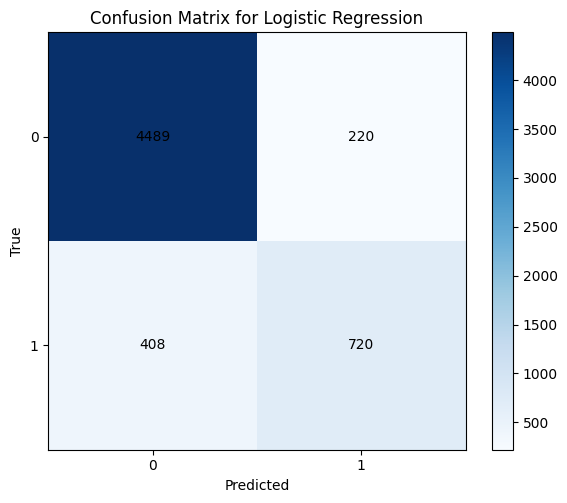

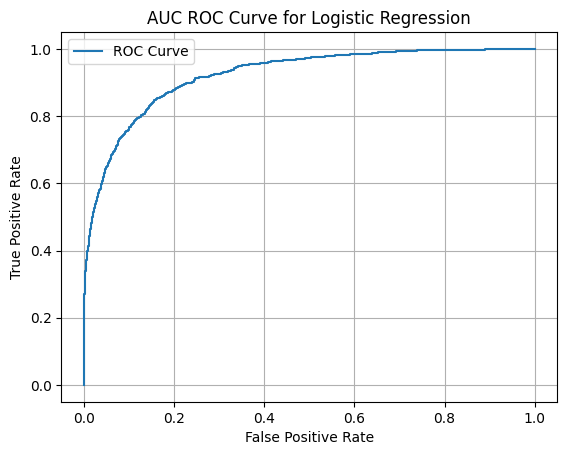

Parameter grid search for Naive Bayes...
Best params: {}
Accuracy: 0.5996230940551653
F1 macro: 0.5543731725709173
ROC AUC: 0.7448064216853498


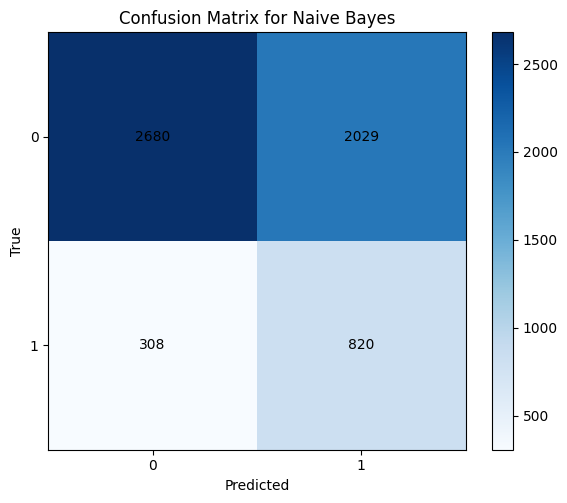

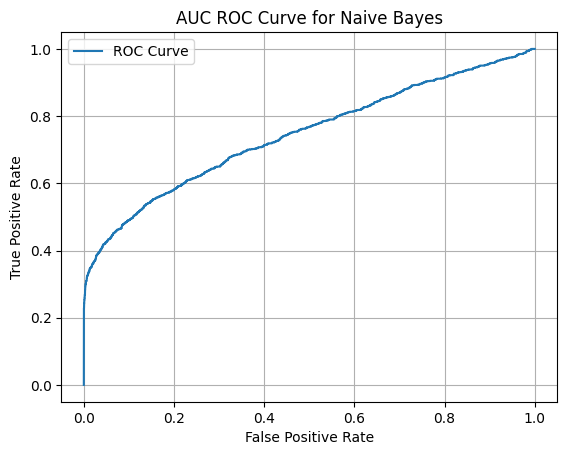

Parameter grid search for SVM...


/opt/homebrew/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number 

Best params: {'classifier__C': 0.5, 'classifier__loss': 'squared_hinge'}
Accuracy: 0.892239163954086
F1 macro: 0.8115083096362907
ROC AUC: 0.9232957412168339


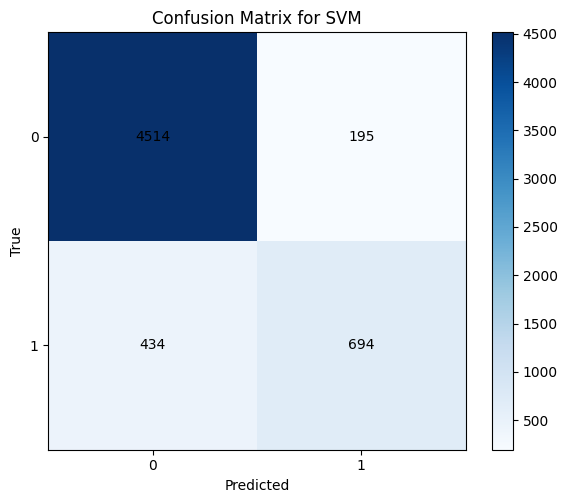

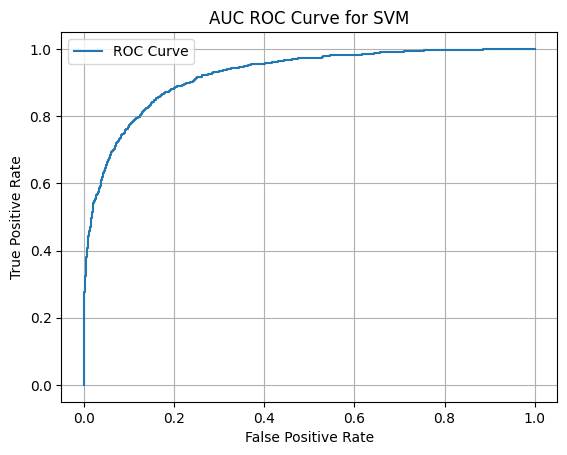


Best model chosen: Logistic Regression, params={'classifier__C': 10}
F1 Macro Score: 0.8154745724283381



In [20]:
binary_classifier(4)
# d = pd.read_csv('test_submission_4.csv')
# d.shape

**Multiclass classification**

Very similar procedure as above, but don't binarize since there are no cutoffs. Have to resplit the test and training data without binary labels but as overall scores instead.

Parameter grid search for Logistic Regression...
Best params: {'classifier__C': 0.5}
F1 macro: 0.5810395325361531
Accuracy: 0.5842042144937468
F1 macro: 0.5840174685379341
ROC AUC: 0.8707658784058507


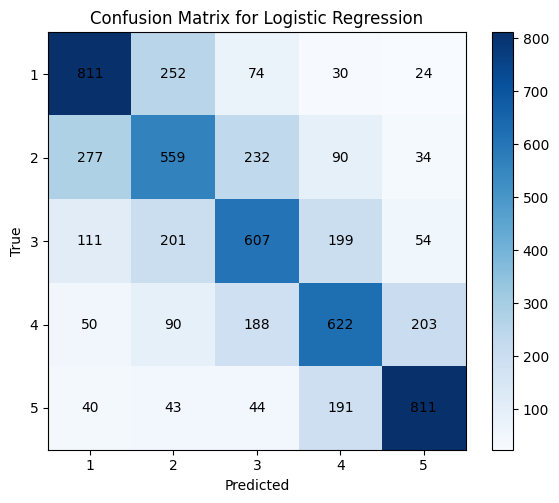

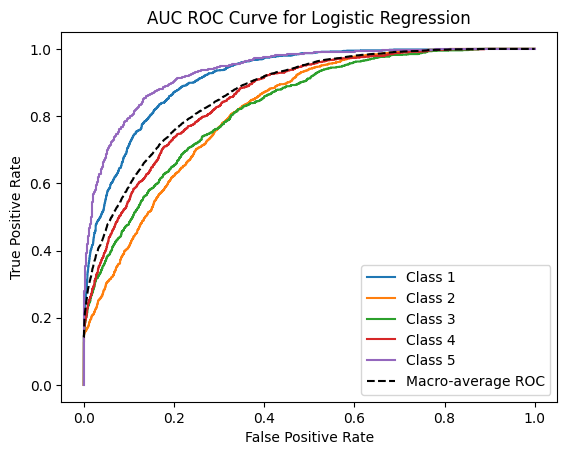

Parameter grid search for Naive Bayes...
Best params: {}
F1 macro: 0.35947345473072156
Accuracy: 0.38170292958711666
F1 macro: 0.3627239116055952
ROC AUC: 0.7164988869670734


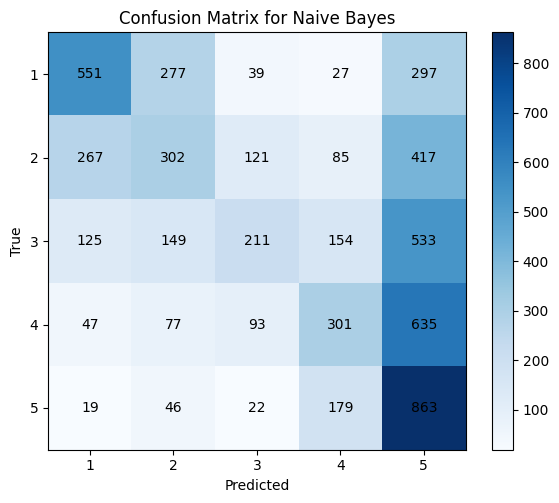

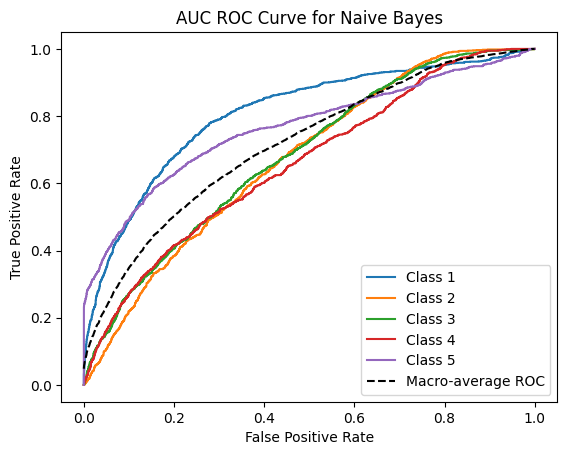

Parameter grid search for SVM...


/opt/homebrew/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number 

Best params: {'classifier__C': 0.1, 'classifier__loss': 'squared_hinge'}
F1 macro: 0.5778850678410531
Accuracy: 0.5838615727257153
F1 macro: 0.5791285686980764
ROC AUC: 0.8598954575818206


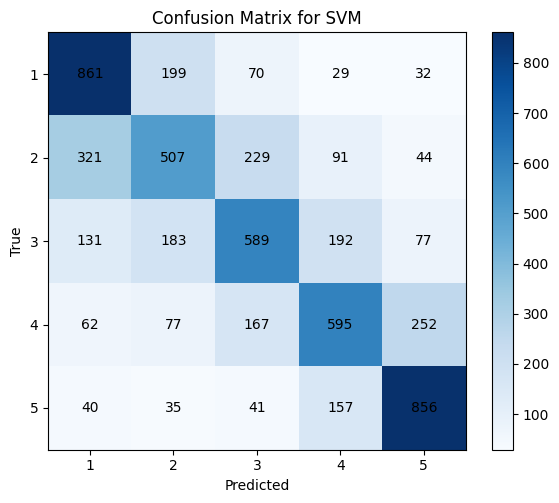

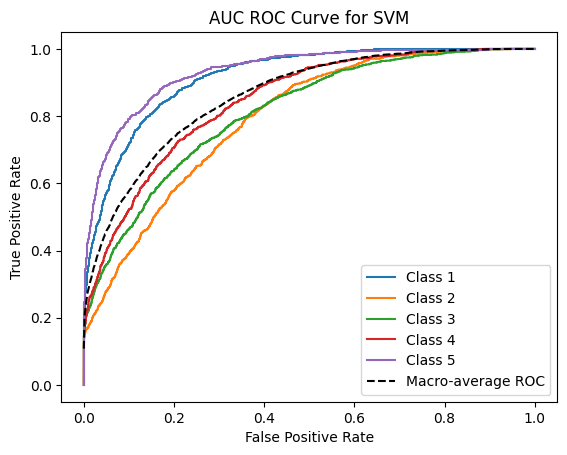

In [21]:
# Split 80-20 without binarizing labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

models = [
    ('Logistic Regression', LogisticRegression(max_iter=3000)),
    ('Naive Bayes', BernoulliNB()),
    ('SVM', LinearSVC(max_iter=3000))
]

parameter_grids = [
    {'classifier__C': [0.1, 0.5, 1, 10]},
    {},  # Naive Bayes has no tunable hyperparams here
    {'classifier__C': [0.1, 0.5, 1, 10], 'classifier__loss': ['hinge', 'squared_hinge']}
]

best_score = -1
best_model = None
best_name = ""
best_params = None

for i, (name, model) in enumerate(models):
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    # Perform 5-folds CV on parameter combinations
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid = GridSearchCV(pipeline, param_grid=parameter_grids[i], cv=cv, scoring='f1_macro', n_jobs=-1)
    
    print(f"Parameter grid search for {name}...")
    grid.fit(X_train, y_train)
    
    print(f"Best params: {grid.best_params_}")
    print(f"F1 macro: {grid.best_score_}")
    
    # Evaluate on validation set
    best = grid.best_estimator_
    y_pred = best.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='macro')
    accuracy = accuracy_score(y_test, y_pred)
    
    try:
        y_proba = best.predict_proba(X_test)
    except:
        # Some models don't have proba, so this was a documented fix to estimate from "decision functions"
        dec = best.decision_function(X_test)
        y_proba = (dec - dec.min()) / (dec.max() - dec.min())

    y_test_bin = label_binarize(y_test, classes=classes)
    roc_auc = roc_auc_score(y_test_bin, y_proba, average='macro', multi_class='ovr')

    print(f"Accuracy: {accuracy}")
    print(f"F1 macro: {f1}")
    print(f"ROC AUC: {roc_auc}")

    # Plots and figures:
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    plt.imshow(cm, cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix for {name}")
    plt.colorbar()
    plt.xticks(np.arange(len(classes)), classes)
    plt.yticks(np.arange(len(classes)), classes)
    for a in range(len(classes)):
        for b in range(len(classes)):
            plt.text(b, a, cm[a, b], ha='center', va='center', color="black")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    # ROC Curve
    fpr = dict()
    tpr = dict()
    for j, class_label in enumerate(classes):
        fpr[j], tpr[j], _ = roc_curve(y_test_bin[:, j], y_proba[:, j])
    for j in range(len(classes)):
        plt.plot(fpr[j], tpr[j], label=f"Class {classes[j]}")

    # Mean AUC ROC curve, macro-averaged
    all_fpr = np.unique(np.concatenate([fpr[j] for j in range(len(classes))]))
    mean_tpr = np.zeros_like(all_fpr)
    for j in range(len(classes)):
        mean_tpr += np.interp(all_fpr, fpr[j], tpr[j])
    mean_tpr /= len(classes)
    plt.plot(all_fpr, mean_tpr, color='black', linestyle='--', label='Macro-average ROC')

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"AUC ROC Curve for {name}")
    plt.legend()
    plt.show()

    # Track best model
    if f1 > best_score:
        best_score = f1
        best_model = best
        best_name = name
        best_params = grid.best_params_


Run the best model to find the F1 macro and then run it on test.csv to make the submission file for Kaggle.

In [22]:
print()
print(f'Best model chosen: {name}, params={best_params}')
print(f'F1 Macro Score: {best_score}')

test_df = pd.read_csv("test.csv")
test_df = test_df[['id', 'reviewText', 'summary', 'category']].copy()
test_df['reviewText'] = test_df['reviewText'].fillna('')
test_df['summary'] = test_df['summary'].fillna('')
test_df['category'] = test_df['category'].fillna('unknown')
test_df = add_features(test_df)

# Predict
test_X = test_df[FEATURES]
test_preds = best_model.predict(test_X)

submission = pd.DataFrame({
    'id': test_df['id'],
    'predicted': test_preds
})

submission.to_csv(f"test_submission.csv", index=False)


Best model chosen: SVM, params={'classifier__C': 0.5}
F1 Macro Score: 0.5840174685379341
